## 1. Učitavanje potrebnih paketa

In [1]:
# Standardne biblioteke
import sys
sys.path.append('../../')

import itertools

# Analiza podataka
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# FinRL i stable_baselines3 za strojno učenje i trgovanje
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_primo_trading.env_primorl import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from stable_baselines3.common.logger import configure

# Konfiguracijski fajlovi i pomoćne funkcije iz FinRL
from finrl.config import INDICATORS, FUNDAMENTAL_INDICATORS
from finrl.main import check_and_make_directories

# Omogućavanje prikaza grafikona unutar Jupyter bilježnice
%matplotlib inline

TRAINED_MODEL_DIR = 'files/models_PORTFOLIO'
RESULTS_DIR = 'files/results_PORTFOLIO'
DATA_DIR = 'files/data_PORTFOLIO'

# Provjera i kreiranje direktorija
check_and_make_directories([TRAINED_MODEL_DIR, DATA_DIR])

## 2. Dohvat podataka

Imamo klasu nazvanu YahooDownloader koja koristi yfinance za dohvaćanje podataka s Yahoo Finance.

U YahooDownloader-u FinRL-a, modificirali smo okvir podataka u oblik koji je pogodan za daljnju obradu podataka. Koristimo prilagođenu zatvarajuću cijenu umjesto zatvarajuće cijene i dodajemo stupac koji predstavlja dan u tjednu (0-4 što odgovara ponedjeljku-petku).

In [2]:
# Intervali za trening i trgovanje
TRAIN_START_DATE = '2021-09-01'
TRAIN_END_DATE = '2023-12-31'
TRADE_START_DATE = '2024-01-01'
TRADE_END_DATE = '2024-07-31'  

Učitavamo podatke iz CSV datoteke koja sadrži generirane značajke od strane PrimoGPT modela.

In [3]:
# Lista dionica
stocks = ["AAPL", "NFLX", "MSFT", "CRM", "AMZN"]

# Učitavanje podataka za svaku dionicu
for stock in stocks:
    file_path = f'data/{stock}_data.csv'
    df_name = f'gpt_predictions_{stock.lower()}'
    
    # Učitavanje CSV datoteke
    globals()[df_name] = pd.read_csv(file_path)
    
    # Preimenovanje stupca 'Date' u 'date'
    globals()[df_name] = globals()[df_name].rename(columns={'Date': 'date'})
    
    # Dodavanje stupca 'tic' s oznakom dionice
    globals()[df_name]['tic'] = stock

In [4]:
gpt_predictions_aapl.head()


,date,Adj Close Price,Returns,Bin Label,News Relevance,Sentiment,Price Impact Potential,Trend Direction,Earnings Impact,Investor Confidence,Risk Profile Change,Prompt,tic
0,2021-09-02,151.119415,0.007475,U1,0,0,0,0,0,0,0,\n [COMPANY BASICS]\n ...,AAPL
1,2021-09-03,151.758759,0.004231,U1,0,0,0,0,0,0,0,\n [COMPANY BASICS]\n ...,AAPL
2,2021-09-07,154.109344,0.015489,U2,0,0,0,0,0,0,0,\n [COMPANY BASICS]\n ...,AAPL
3,2021-09-08,152.555389,-0.010083,D2,0,0,0,0,0,0,0,\n [COMPANY BASICS]\n ...,AAPL
4,2021-09-09,151.532532,-0.006705,D1,0,0,0,0,0,0,0,\n [COMPANY BASICS]\n ...,AAPL


In [5]:
# Preuzimamo sve podatke
df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                         end_date = TRADE_END_DATE,
                         ticker_list = ["AAPL", "NFLX", "MSFT", "CRM", "AMZN"]).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (3655, 8)


In [6]:
df_raw.head()

,date,open,high,low,close,volume,tic,day
0,2021-09-01,152.830002,154.979996,152.339996,149.998215,80313700,AAPL,2
1,2021-09-01,174.820007,176.350006,173.761993,173.949997,72598000,AMZN,2
2,2021-09-01,266.269989,273.260010,265.589996,267.553497,7189000,CRM,2
3,2021-09-01,302.869995,305.190002,301.489990,294.250427,18983800,MSFT,2
4,2021-09-01,569.000000,591.000000,569.000000,582.070007,5626200,NFLX,2


## 3. Procesiranje podataka

Koristimo definiranu klasu FeatureEngineer pomoću koje radimo procesiranje podataka i dodavanje tehničkih indikatora.

Opcija use_vix uključuje VIX indeks, poznat kao "indeks straha", koji predstavlja očekivanu volatilnost tržišta dionica temeljenu na opcijama S&P 500 indeksa. VIX pomaže modelu da razumije tržišnu nesigurnost, s višim vrijednostima koje ukazuju na veću nesigurnost.

Opcija use_turbulence uključuje indeks turbulencije, koji mjeri neobične tržišne fluktuacije i služi kao pokazatelj rizika i tržišnih šokova. Koristan je za identifikaciju perioda visoke volatilnosti, pomažući modelu da se prilagodi financijskim krizama.

Inače dosta zgodna klasa koja sadrži korisne metode za obradu financijskih podataka i može se primjeniti u brojne druge svrhe.

In [7]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df_raw)

Successfully added technical indicators


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (730, 8)
Successfully added vix


Successfully added turbulence index


In [8]:
# Stvara listu jedinstvenih oznaka dionica (tickers) iz stupca 'tic' DataFrame-a 'processed'.
list_ticker = processed["tic"].unique().tolist()

# Stvara listu datuma između najranijeg i najkasnijeg datuma u DataFrame-u 'processed', pretvara ih u stringove.
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))

# Stvara kombinacije svih datuma i oznaka dionica koristeći kartezijev produkt.
combination = list(itertools.product(list_date,list_ticker))

# Stvara novi DataFrame 'processed_full' s kolonama "date" i "tic", koji sadrži sve kombinacije datuma i oznaka dionica.
# Spaja taj DataFrame s originalnim DataFrame-om 'processed' na temelju kolona "date" i "tic", koristeći 'left' spajanje.
processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")

# Filtrira 'processed_full' DataFrame da sadrži samo one retke čiji su datumi prisutni u originalnom DataFrame-u 'processed'.
processed_full = processed_full[processed_full['date'].isin(processed['date'])]

# Sortira 'processed_full' DataFrame po datumu i oznaci dionica.
processed_full = processed_full.sort_values(['date','tic'])

# Zamjenjuje sve nedostajuće vrijednosti (NaN) s 0 u DataFrame-u 'processed_full'.
processed_full = processed_full.fillna(0)

In [9]:
processed_full.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-09-01,AAPL,152.830002,154.979996,152.339996,149.998215,80313700.0,2.0,0.0,152.14449,148.97317,100.0,66.666667,100.0,149.998215,149.998215,16.110001,0.0
1,2021-09-01,AMZN,174.820007,176.350006,173.761993,173.949997,72598000.0,2.0,0.0,152.14449,148.97317,100.0,66.666667,100.0,173.949997,173.949997,16.110001,0.0
2,2021-09-01,CRM,266.269989,273.260010,265.589996,267.553497,7189000.0,2.0,0.0,152.14449,148.97317,100.0,66.666667,100.0,267.553497,267.553497,16.110001,0.0
3,2021-09-01,MSFT,302.869995,305.190002,301.489990,294.250427,18983800.0,2.0,0.0,152.14449,148.97317,100.0,66.666667,100.0,294.250427,294.250427,16.110001,0.0
4,2021-09-01,NFLX,569.000000,591.000000,569.000000,582.070007,5626200.0,2.0,0.0,152.14449,148.97317,100.0,66.666667,100.0,582.070007,582.070007,16.110001,0.0


Radimo spajanje ovih preuzetih podataka s podacima iz CSV datoteke koja sadrži generirane značajke od strane PrimoGPT modela.

In [10]:
# Stupci koje želimo zadržati iz GPT predikcija
columns_to_keep = ['date', 'News Relevance', 'Sentiment', 'Price Impact Potential', 
                   'Trend Direction', 'Earnings Impact', 'Investor Confidence', 'Risk Profile Change']

# Mapiranje za preimenovanje stupaca
column_mapping = {
    'News Relevance': 'news_relevance',
    'Sentiment': 'sentiment',
    'Price Impact Potential': 'price_impact_potential',
    'Trend Direction': 'trend_direction',
    'Earnings Impact': 'earnings_impact',
    'Investor Confidence': 'investor_confidence',
    'Risk Profile Change': 'risk_profile_change'
}

# Priprema podataka za AAPL
gpt_data_aapl = gpt_predictions_aapl[columns_to_keep]
gpt_data_aapl = gpt_data_aapl.rename(columns=column_mapping)
gpt_data_aapl['tic'] = 'AAPL'

# Spajanje podataka samo za AAPL redove
processed_full = processed_full.merge(gpt_data_aapl, on=['date', 'tic'], how='left')

# Popunjavanje NaN vrijednosti s 0 samo za nove stupce
new_columns = list(column_mapping.values())
processed_full[new_columns] = processed_full[new_columns].fillna(0)


In [11]:
# Mapiranje za preimenovanje stupaca
column_mapping = {
    'News Relevance': 'news_relevance',
    'Sentiment': 'sentiment',
    'Price Impact Potential': 'price_impact_potential',
    'Trend Direction': 'trend_direction',
    'Earnings Impact': 'earnings_impact',
    'Investor Confidence': 'investor_confidence',
    'Risk Profile Change': 'risk_profile_change'
}

# Priprema podataka za NFLX
gpt_data_nflx = gpt_predictions_nflx[['date'] + list(column_mapping.keys())]
gpt_data_nflx = gpt_data_nflx.rename(columns=column_mapping)
gpt_data_nflx['tic'] = 'NFLX'

# Ažuriranje podataka samo za NFLX redove
for column in column_mapping.values():
    processed_full.loc[processed_full['tic'] == 'NFLX', column] = processed_full.loc[processed_full['tic'] == 'NFLX'].merge(
        gpt_data_nflx[['date', 'tic', column]], 
        on=['date', 'tic'], 
        how='left'
    )[f'{column}_y'].fillna(processed_full[column])

In [12]:
# Mapiranje za preimenovanje stupaca
column_mapping = {
    'News Relevance': 'news_relevance',
    'Sentiment': 'sentiment',
    'Price Impact Potential': 'price_impact_potential',
    'Trend Direction': 'trend_direction',
    'Earnings Impact': 'earnings_impact',
    'Investor Confidence': 'investor_confidence',
    'Risk Profile Change': 'risk_profile_change'
}

# Priprema podataka za NFLX
gpt_data_msft = gpt_predictions_msft[['date'] + list(column_mapping.keys())]
gpt_data_msft = gpt_data_msft.rename(columns=column_mapping)
gpt_data_msft['tic'] = 'MSFT'

# Ažuriranje podataka samo za NFLX redove
for column in column_mapping.values():
    processed_full.loc[processed_full['tic'] == 'MSFT', column] = processed_full.loc[processed_full['tic'] == 'MSFT'].merge(
        gpt_data_msft[['date', 'tic', column]], 
        on=['date', 'tic'], 
        how='left'
    )[f'{column}_y'].fillna(processed_full[column])

In [13]:
# Mapiranje za preimenovanje stupaca
column_mapping = {
    'News Relevance': 'news_relevance',
    'Sentiment': 'sentiment',
    'Price Impact Potential': 'price_impact_potential',
    'Trend Direction': 'trend_direction',
    'Earnings Impact': 'earnings_impact',
    'Investor Confidence': 'investor_confidence',
    'Risk Profile Change': 'risk_profile_change'
}

# Priprema podataka za NFLX
gpt_data_crm = gpt_predictions_crm[['date'] + list(column_mapping.keys())]
gpt_data_crm = gpt_data_crm.rename(columns=column_mapping)
gpt_data_crm['tic'] = 'CRM'

# Ažuriranje podataka samo za NFLX redove
for column in column_mapping.values():
    processed_full.loc[processed_full['tic'] == 'CRM', column] = processed_full.loc[processed_full['tic'] == 'CRM'].merge(
        gpt_data_crm[['date', 'tic', column]], 
        on=['date', 'tic'], 
        how='left'
    )[f'{column}_y'].fillna(processed_full[column])

In [14]:
# Mapiranje za preimenovanje stupaca
column_mapping = {
    'News Relevance': 'news_relevance',
    'Sentiment': 'sentiment',
    'Price Impact Potential': 'price_impact_potential',
    'Trend Direction': 'trend_direction',
    'Earnings Impact': 'earnings_impact',
    'Investor Confidence': 'investor_confidence',
    'Risk Profile Change': 'risk_profile_change'
}

# Priprema podataka za NFLX
gpt_data_amzn = gpt_predictions_amzn[['date'] + list(column_mapping.keys())]
gpt_data_amzn = gpt_data_amzn.rename(columns=column_mapping)
gpt_data_amzn['tic'] = 'AMZN'

# Ažuriranje podataka samo za NFLX redove
for column in column_mapping.values():
    processed_full.loc[processed_full['tic'] == 'AMZN', column] = processed_full.loc[processed_full['tic'] == 'AMZN'].merge(
        gpt_data_amzn[['date', 'tic', column]], 
        on=['date', 'tic'], 
        how='left'
    )[f'{column}_y'].fillna(processed_full[column])

In [15]:
# Zamjenjuje sve nedostajuće vrijednosti (NaN) s 0 u DataFrame-u 'processed_full'.
processed_full = processed_full.fillna(0)

In [16]:
processed_full.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,...,close_60_sma,vix,turbulence,news_relevance,sentiment,price_impact_potential,trend_direction,earnings_impact,investor_confidence,risk_profile_change
0,2021-09-01,AAPL,152.830002,154.979996,152.339996,149.998215,80313700.0,2.0,0.0,152.14449,...,149.998215,16.110001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-09-01,AMZN,174.820007,176.350006,173.761993,173.949997,72598000.0,2.0,0.0,152.14449,...,173.949997,16.110001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-09-01,CRM,266.269989,273.260010,265.589996,267.553497,7189000.0,2.0,0.0,152.14449,...,267.553497,16.110001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-09-01,MSFT,302.869995,305.190002,301.489990,294.250427,18983800.0,2.0,0.0,152.14449,...,294.250427,16.110001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-09-01,NFLX,569.000000,591.000000,569.000000,582.070007,5626200.0,2.0,0.0,152.14449,...,582.070007,16.110001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Pripremamo trening i trade set sukladno definiranim datumima
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

2930
720


In [18]:
# Spremamo podatke
train.to_csv('train_data.csv')
trade.to_csv('trade_data.csv')

## 4. Priprema environmenta

stock_dimension predstavlja broj jedinstvenih dionica u skupu podataka. Ova vrijednost se koristi za određivanje koliko različitih dionica model može trgovati.

state_space označava ukupnu veličinu prostora stanja koji model koristi za donošenje odluka. Prostor stanja uključuje trenutne podatke o dionicama (kao što su cijene i tehnički indikatori) i informacije o trenutnom portfelju (kao što su broj dionica koje posjeduje). Veličina prostora stanja određena je formulom koja uzima u obzir broj dionica i broj tehničkih indikatora.

In [19]:
# Izračunavamo dimenziju (broj jedinstvenih dionica) iz DataFrame-a 'train'.
stock_dimension = len(train.tic.unique())

# Izračunavamo veličinu stanja na temelju dimenzije i broja tehničkih indikatora.
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension + len(FUNDAMENTAL_INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 5, State Space: 86


In [20]:
# Stvara liste troškova kupnje i prodaje za svaku dionicu.
buy_cost_list = sell_cost_list = [0] * stock_dimension

# Inicijalizira broj dionica za svaku dionicu na 0.
num_stock_shares = [0] * stock_dimension

e_train_gym je instanca klase StockTradingEnv, koja predstavlja okruženje za trgovanje. Ovo okruženje koristi podatke i parametre definirane za simulaciju tržišta dionica. Model uči kako trgovati unutar ovog okruženja, pokušavajući maksimizirati ukupnu nagradu (profit) kroz seriju trgovačkih odluka.

env_train dobiva se pozivom metode get_sb_env() na instanci e_train_gym. Ova metoda vraća okruženje kompatibilno s bibliotekom Stable Baselines 3, koja se koristi za implementaciju algoritama pojačanog učenja. Drugi povratni element, koji se ovdje ignorira (_), može se koristiti za dodatne informacije ili funkcionalnosti koje pruža okruženje.

In [21]:
# Definira argumente za okruženje trgovanja.
env_kwargs = {
    "hmax": 1000,  # Maksimalni broj dionica koje se mogu kupiti ili prodati u jednoj transakciji.
    "initial_amount": 100000,  # Početni iznos kapitala.
    "num_stock_shares": num_stock_shares,  # PPočetni broj dionica svake dionice u portfelju, inicijalno postavljen na 0.
    "buy_cost_pct": buy_cost_list,  # Postotci troškova za kupnju i prodaju dionica, odnosno, koji simuliraju stvarne troškove transakcija.
    "sell_cost_pct": sell_cost_list,  # Postotci troškova za kupnju i prodaju dionica, odnosno, koji simuliraju stvarne troškove transakcija.
    "state_space": state_space,  # Prije definirane veličine koje utječu na strukturu okruženja.
    "stock_dim": stock_dimension,  # Prije definirane veličine koje utječu na strukturu okruženja.
    "tech_indicator_list": INDICATORS,  # Lista tehničkih indikatora koji će se koristiti za analizu stanja tržišta.
    "fundamental_indicator_list": FUNDAMENTAL_INDICATORS,  # Lista fundamentalnih indikatora koji će se koristiti za analizu stanja tržišta.
    "action_space": stock_dimension,  # Veličina prostora akcija, odnosno, broj različitih akcija koje model može izvršiti.
    "reward_scaling": 1e-2,  # Faktor skaliranja za nagradu, koristi se za prilagodbu veličine nagrade kako bi se olakšalo učenje.
    "verbose": 0
}

# Kreira okruženje za treniranje.
e_train_gym = StockTradingEnv(df = train, **env_kwargs)

# Dohvaća okruženje pogodno za Stable Baselines i neiskorišteni objekt.
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


## 5. Trening DRL agenata

Ovdje su algoritmi dubokog pojačanog učenja (DRL) iz biblioteke Stable Baselines 3. Radi se o biblioteci koja je implementirala popularne DRL algoritme koristeći PyTorch.

Kao zamjena mogu se koristiti biblioteke ElegantRL i Ray RLlib.

In [22]:
# Kreira instancu DRL agenta s predanim okruženjem za treniranje.
agent = DRLAgent(env = env_train)

# Postavljanje odgovarajućih vrijednosti na 'True' za algoritme koje želite koristiti
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = False
if_using_sac = True

### Trening 5 različitih DRL agenata (A2C, DDPG, PPO, TD3, SAC)

#### Agent 1: A2C

In [23]:
# Ponovno se kreira instanca DRL agenta s predanim okruženjem (nije potrebno ponovno raditi, ali zbog lakših uputa neka stoji)
agent = DRLAgent(env = env_train)
# Dohvaća model A2C pomoću metode get_model
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # Postavljanje loggera za praćenje i zapisivanje informacija tijekom treniranja
  tmp_path = RESULTS_DIR + '/a2c'
  # Konfigurira novi logger koji će ispisivati informacije na standardni izlaz, zapisivati u CSV datoteku i TensorBoard
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Postavlja novi logger za model A2C.
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to files/results_PORTFOLIO/a2c


In [24]:
# Trenira model A2C s definiranim ukupnim brojem vremenskih koraka, samo ako je if_using_a2c postavljen na True.
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000) if if_using_a2c else None

----------------------------------------
| time/                 |              |
|    fps                | 1012         |
|    iterations         | 100          |
|    time_elapsed       | 0            |
|    total_timesteps    | 500          |
| train/                |              |
|    entropy_loss       | -7.17        |
|    explained_variance | -144         |
|    learning_rate      | 0.0007       |
|    n_updates          | 99           |
|    policy_loss        | -0.606       |
|    reward             | 0.0011428171 |
|    std                | 1.02         |
|    value_loss         | 0.0238       |
----------------------------------------
------------------------------------------
| time/                 |                |
|    fps                | 1020           |
|    iterations         | 200            |
|    time_elapsed       | 0              |
|    total_timesteps    | 1000           |
| train/                |                |
|    entropy_loss       | -7.21          |


In [25]:
# Sprema trenirani model A2C u definirani direktorij, samo ako je if_using_a2c postavljen na True.
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

#### Agent 2: DDPG

In [26]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to files/results_PORTFOLIO/ddpg


In [27]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

Day: 585, episode: 90
Begin total asset: 100000.00
End total asset: 83695.33
Total reward: -16304.67
Total cost: 0.00
Total trades: 3
Sharpe: 0.135
--------------------------------------
| time/              |               |
|    episodes        | 4             |
|    fps             | 190           |
|    time_elapsed    | 12            |
|    total_timesteps | 2344          |
| train/             |               |
|    actor_loss      | -0.117        |
|    critic_loss     | 0.262         |
|    learning_rate   | 0.001         |
|    n_updates       | 2243          |
|    reward          | 0.00035364795 |
--------------------------------------
--------------------------------------
| time/              |               |
|    episodes        | 8             |
|    fps             | 187           |
|    time_elapsed    | 24            |
|    total_timesteps | 4688          |
| train/             |               |
|    actor_loss      | -4.79         |
|    critic_loss     | 0.0951    

In [28]:

trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

#### Agent 3: PPO

In [29]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to files/results_PORTFOLIO/ppo


In [30]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=200000) if if_using_ppo else None

--------------------------------------
| time/              |               |
|    fps             | 1493          |
|    iterations      | 1             |
|    time_elapsed    | 1             |
|    total_timesteps | 2048          |
| train/             |               |
|    reward          | -0.0049868347 |
--------------------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 1391           |
|    iterations           | 2              |
|    time_elapsed         | 2              |
|    total_timesteps      | 4096           |
| train/                  |                |
|    approx_kl            | 0.0069679413   |
|    clip_fraction        | 0.0588         |
|    clip_range           | 0.2            |
|    entropy_loss         | -7.1           |
|    explained_variance   | -8.21          |
|    learning_rate        | 0.00025        |
|    loss                 | -0.0738        |
|    n_updates     

In [31]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

#### Agent 4: TD3

In [32]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [33]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

In [34]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

#### Agent 5: SAC

In [35]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to files/results_PORTFOLIO/sac


In [36]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=70000) if if_using_sac else None

Day: 585, episode: 520
Begin total asset: 100000.00
End total asset: 45260.34
Total reward: -54739.66
Total cost: 0.00
Total trades: 692
Sharpe: -0.687
--------------------------------------
| time/              |               |
|    episodes        | 4             |
|    fps             | 202           |
|    time_elapsed    | 11            |
|    total_timesteps | 2344          |
| train/             |               |
|    actor_loss      | 30.7          |
|    critic_loss     | 3.88          |
|    ent_coef        | 0.1           |
|    ent_coef_loss   | -0.769        |
|    learning_rate   | 0.0001        |
|    n_updates       | 2243          |
|    reward          | -0.0021271217 |
--------------------------------------
--------------------------------------
| time/              |               |
|    episodes        | 8             |
|    fps             | 201           |
|    time_elapsed    | 23            |
|    total_timesteps | 4688          |
| train/             |       

In [37]:
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

## 6. Priprema za backtest

In [38]:
# Po potrebi učitavamo sporemnjene podatke ako smo restrartali proces (nije potrebno)
train = pd.read_csv('train_data.csv')
trade = pd.read_csv('trade_data.csv')

train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [39]:
# Po potrebi učitavamo sporemnjene podatke o treningu agenata ako smo restrartali proces (nije potrebno)
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = False
if_using_sac = True

trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None
trained_sac = SAC.load(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

## 7. Trgovanje (podatci izvan trening seta)

Ovdje sada za trgovanje koristimo trade skup podataka koji nikad nije bio korišten za trening. Dodatno sličnim pristupom bi mogli i dotrenirati postojeći spremljeni model.

Brojni hiperparametri, na primjer, stopa učenja, ukupan broj uzoraka za trening – utječu na proces učenja i obično se određuju testiranjem nekih varijacija.

In [40]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension + len(FUNDAMENTAL_INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 5, State Space: 86


In [41]:
buy_cost_list = sell_cost_list = [0] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 1000,
    "initial_amount": 100000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "fundamental_indicator_list": FUNDAMENTAL_INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-2,
    "verbose": 1
}

Ovaj dio se odnosi se na korištenje dubokog pojačanog učenja (DRL) za simulaciju trgovanja u stvarnom vremenu koristeći prethodno trenirani model (u ovom slučaju, A2C). StockTradingEnv je okruženje koje simulira tržište dionica s obzirom na povijesne podatke, prag turbulencije (koji se koristi za određivanje volatilnosti tržišta), i 'VIX' kao pokazatelj rizika. Nakon inicijalizacije okruženja, koristi se metoda get_sb_env() za dohvaćanje okruženja i početne opservacije koje su kompatibilne sa Stable Baselines bibliotekom.

In [42]:
# Inicijalizacija okruženja za trgovanje s definiranim DataFrame-om 'trade', pragom turbulencije i pokazateljem rizika 'vix',
# zajedno s ostalim parametrima okruženja ('env_kwargs').
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

# Dohvaćanje okruženja kompatibilnog sa Stable Baselines i početne opservacije.
env_trade, obs_trade = e_trade_gym.get_sb_env()

Initialized environment with 5 stocks
Technical indicators: ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']
Fundamental indicators: ['news_relevance', 'sentiment', 'price_impact_potential', 'trend_direction', 'earnings_impact', 'investor_confidence', 'risk_profile_change']
Initial amount: 100000
Initial stock shares: [0, 0, 0, 0, 0]

Resetting environment. Episode: 0
Initial state: [100000, 184.9382171630859, 149.92999267578125, 255.3983154296875, 368.8540954589844, 468.5, 0, 0, 0, 0, 0, 0.7945257324362274, 2.427521510355234, 8.39669665844238, 2.2442378552293007, 8.706174626749828, 199.09309955577328, 156.67876227644464, 271.0956383163022, 375.4639581560313, 507.11976613443017, 187.49693035145327, 143.2592366859577, 244.89708476719392, 365.27965146310936, 441.2752350862729, 47.63133984232509, 56.34390611541345, 61.613787533482096, 55.339109444508495, 54.37993733404732, -194.105283911798, 36.69766413456144, 38.41188702524301, -55.2016647045412

Zatim se DRL agent koristi za predviđanje akcija trgovanja i promjene u vrijednosti računa na temelju treniranog modela. To omogućuje evaluaciju performansi modela u scenariju izvan uzorka, pružajući uvid u to kako bi model mogao performirati u stvarnim trgovačkim uvjetima. Ako je odabrana upotreba A2C algoritma (kao što je indicirano varijablom if_using_a2c), provodi se predviđanje; u suprotnom, rezultat se postavlja na None.

In [43]:
# Korištenje DRL agenta za predviđanje koristeći trenirani model 'trained_a2c' i definirano okruženje trgovanja 'e_trade_gym'.
# Rezultati su dva DataFrame-a: 'df_account_value_a2c' s vrijednostima računa i 'df_actions_a2c' s akcijama koje su poduzete,
# ako je 'if_using_a2c' postavljen na True; inače se vraća (None, None).
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym) if if_using_a2c else (None, None)


Resetting environment. Episode: 1
Initial state: [100000, 184.9382171630859, 149.92999267578125, 255.3983154296875, 368.8540954589844, 468.5, 0, 0, 0, 0, 0, 0.7945257324362274, 2.427521510355234, 8.39669665844238, 2.2442378552293007, 8.706174626749828, 199.09309955577328, 156.67876227644464, 271.0956383163022, 375.4639581560313, 507.11976613443017, 187.49693035145327, 143.2592366859577, 244.89708476719392, 365.27965146310936, 441.2752350862729, 47.63133984232509, 56.34390611541345, 61.613787533482096, 55.339109444508495, 54.37993733404732, -194.105283911798, 36.69766413456144, 38.41188702524301, -55.20166470454128, -17.70302923427912, 9.321965634334738, 6.96204526018845, 25.782184511448136, 13.649035894526158, 20.523060643530112, 192.08377634684248, 148.7413330078125, 248.805859375, 371.8722696940104, 474.3970011393229, 184.59083557128903, 141.23350003560384, 227.7937240600586, 356.41209818522134, 441.06283315022785, 2.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, -2.0, 0.0, 0.0, 0

In [44]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym) if if_using_ddpg else (None, None)


Resetting environment. Episode: 4
Initial state: [100000, 184.9382171630859, 149.92999267578125, 255.3983154296875, 368.8540954589844, 468.5, 0, 0, 0, 0, 0, 0.7945257324362274, 2.427521510355234, 8.39669665844238, 2.2442378552293007, 8.706174626749828, 199.09309955577328, 156.67876227644464, 271.0956383163022, 375.4639581560313, 507.11976613443017, 187.49693035145327, 143.2592366859577, 244.89708476719392, 365.27965146310936, 441.2752350862729, 47.63133984232509, 56.34390611541345, 61.613787533482096, 55.339109444508495, 54.37993733404732, -194.105283911798, 36.69766413456144, 38.41188702524301, -55.20166470454128, -17.70302923427912, 9.321965634334738, 6.96204526018845, 25.782184511448136, 13.649035894526158, 20.523060643530112, 192.08377634684248, 148.7413330078125, 248.805859375, 371.8722696940104, 474.3970011393229, 184.59083557128903, 141.23350003560384, 227.7937240600586, 356.41209818522134, 441.06283315022785, 2.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, -2.0, 0.0, 0.0, 0

In [45]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym) if if_using_ppo else (None, None)


Resetting environment. Episode: 7
Initial state: [100000, 184.9382171630859, 149.92999267578125, 255.3983154296875, 368.8540954589844, 468.5, 0, 0, 0, 0, 0, 0.7945257324362274, 2.427521510355234, 8.39669665844238, 2.2442378552293007, 8.706174626749828, 199.09309955577328, 156.67876227644464, 271.0956383163022, 375.4639581560313, 507.11976613443017, 187.49693035145327, 143.2592366859577, 244.89708476719392, 365.27965146310936, 441.2752350862729, 47.63133984232509, 56.34390611541345, 61.613787533482096, 55.339109444508495, 54.37993733404732, -194.105283911798, 36.69766413456144, 38.41188702524301, -55.20166470454128, -17.70302923427912, 9.321965634334738, 6.96204526018845, 25.782184511448136, 13.649035894526158, 20.523060643530112, 192.08377634684248, 148.7413330078125, 248.805859375, 371.8722696940104, 474.3970011393229, 184.59083557128903, 141.23350003560384, 227.7937240600586, 356.41209818522134, 441.06283315022785, 2.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, -2.0, 0.0, 0.0, 0

In [46]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym) if if_using_td3 else (None, None)

In [47]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym) if if_using_sac else (None, None)


Resetting environment. Episode: 10
Initial state: [100000, 184.9382171630859, 149.92999267578125, 255.3983154296875, 368.8540954589844, 468.5, 0, 0, 0, 0, 0, 0.7945257324362274, 2.427521510355234, 8.39669665844238, 2.2442378552293007, 8.706174626749828, 199.09309955577328, 156.67876227644464, 271.0956383163022, 375.4639581560313, 507.11976613443017, 187.49693035145327, 143.2592366859577, 244.89708476719392, 365.27965146310936, 441.2752350862729, 47.63133984232509, 56.34390611541345, 61.613787533482096, 55.339109444508495, 54.37993733404732, -194.105283911798, 36.69766413456144, 38.41188702524301, -55.20166470454128, -17.70302923427912, 9.321965634334738, 6.96204526018845, 25.782184511448136, 13.649035894526158, 20.523060643530112, 192.08377634684248, 148.7413330078125, 248.805859375, 371.8722696940104, 474.3970011393229, 184.59083557128903, 141.23350003560384, 227.7937240600586, 356.41209818522134, 441.06283315022785, 2.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, -2.0, 0.0, 0.0, 

## 8. Mean Variance optimizacija

Optimizacija srednje varijance je klasična strategija upravljanja portfeljem. Ovdje prolazimo kroz cijeli proces da bismo izvršili optimizaciju srednje varijance i dodali je kao osnovu za usporedbu (benchmark).

Naredni kod implementira optimizaciju srednje varijance (MVO) za upravljanje portfeljem. Počinje pripremom podataka za izračun težina MVO, sortiranjem podataka i izvlačenjem zatvarajućih cijena. Zatim koristi te podatke za izračunavanje dnevnih povrata dionica, te na temelju toga izračunava prosječne povrate i kovarijacijsku matricu povrata. Ovi statistički podaci su temelj za daljnje analize i odluke u upravljanju portfeljem, pružajući uvid u očekivane povrate i rizike povezane s različitim dionicama u portfelju.

Obrađujemo DataFrame za izračun težina srednje varijance.

In [48]:
# Funkcija za pripremu DataFrame-a za izračun težina optimizacije srednje varijance (MVO)
def process_df_for_mvo(df):
  # Sortira DataFrame po datumu i oznaci dionice, a zatim selektira samo relevantne stupce
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  # Uzima podskup podataka za prvu dimenziju dionica
  fst = df.iloc[0:stock_dimension, :]
  # Izvlači popis oznaka dionica
  tic = fst['tic'].tolist()

  # Inicijalizira prazan DataFrame za MVO
  mvo = pd.DataFrame()

  # Postavlja početne vrijednosti težina na 0 za svaku dionicu
  for k in range(len(tic)):
    mvo[tic[k]] = 0

  # Popunjava DataFrame 'mvo' zatvarajućim cijenama za svaku dionicu po datumima
  for i in range(df.shape[0]//stock_dimension):
    n = df.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()
  
  return mvo

In [49]:
# Funkcija za izračun povrata dionica na temelju njihovih cijena
def StockReturnsComputing(StockPrice, Rows, Columns): 
  import numpy as np 
  # Inicijalizira matricu povrata.
  StockReturn = np.zeros([Rows-1, Columns]) 
  # Računa dnevni povrat za svaku dionicu
  for j in range(Columns):        # j: Assets 
    for i in range(Rows-1):       # i: Daily Prices 
      StockReturn[i,j] = ((StockPrice[i+1, j] - StockPrice[i,j]) / StockPrice[i,j]) * 100 
      
  return StockReturn

In [50]:
# Primjena funkcije na trening i trade
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

# Pretvara TradeData u numpy niz
TradeData.to_numpy()

array([[184.93821716, 149.92999268, 255.39831543, 368.85409546,
        468.5       ],
       [183.55348206, 148.47000122, 251.12055969, 368.58557129,
        470.26000977],
       [181.22233582, 144.57000732, 250.52227783, 365.94000244,
        474.67001343],
       [180.49507141, 145.24000549, 250.40260315, 365.75106812,
        474.05999756],
       [184.85852051, 149.1000061 , 260.12475586, 372.65335083,
        485.02999878],
       [184.44010925, 151.36999512, 260.59341431, 373.74734497,
        482.08999634],
       [185.48614502, 153.72999573, 263.37545776, 380.68942261,
        478.32998657],
       [184.88841248, 155.17999268, 270.60473633, 382.53930664,
        492.23001099],
       [185.21716309, 154.61999512, 271.15316772, 386.35842896,
        492.16000366],
       [182.93582153, 153.16000366, 268.42102051, 388.14865112,
        481.23999023],
       [181.9894104 , 151.71000671, 270.66455078, 387.35299683,
        480.32998657],
       [187.91693115, 153.5       , 273.675

In [51]:
# Izračunava povrat po imovini
arStockPrices = np.asarray(StockData)
[Rows, Cols] = arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

# Izračunava prosječne povrate i kovarijacijsku matricu povrata
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)
 
# Postavlja preciznost za ispis rezultata.
np.set_printoptions(precision=3, suppress = True)

# Prikazuje prosječne povrate i kovarijacijsku matricu povrata
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.058 0.009 0.026 0.058 0.029]
Variance-Covariance matrix of returns
 [[ 3.196  2.806  2.532  2.43   2.778]
 [ 2.806  6.467  3.777  3.217  4.389]
 [ 2.532  3.777  5.972  2.839  3.961]
 [ 2.43   3.217  2.839  3.483  2.831]
 [ 2.778  4.389  3.961  2.831 11.177]]


### Korsitimo sada PyPortfolioOpt

In [52]:
# Učitavanje klase EfficientFrontier iz PyPortfolioOpt biblioteke
from pypfopt.efficient_frontier import EfficientFrontier

# Inicijalizacija objekta EfficientFrontier s prosječnim povratima i kovarijacijskom matricom povrata
# Ograničenja težine su postavljena tako da nijedna imovina ne može činiti više od 50% portfelja
ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))

# Izračunavanje sirovih težina za maksimalni Sharpeov omjer
raw_weights_mean = ef_mean.max_sharpe()

# Čišćenje težina kako bi se zaokružile vrlo male težine na 0 i normalizirale ostale
cleaned_weights_mean = ef_mean.clean_weights()

# Pretvorba čistih težina u stvarne iznose ulaganja, pretpostavljajući početni kapital od 1,000,000
mvo_weights = np.array([100000 * cleaned_weights_mean[i] for i in range(5)])
print(mvo_weights)

# Izračunavanje cijene posljednje dionice u datasetu kako bi se odredile početne količine dionica.
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])

# Izračunavanje početnog portfelja množenjem iznosa ulaganja s posljednjom cijenom.
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
print(Initial_Portfolio)

# Izračunavanje vrijednosti portfelja koristeći trgovinske podatke i početne količine dionica.
Portfolio_Assets = TradeData @ Initial_Portfolio

# Stvaranje DataFrame-a s rezultatima optimizacije srednje varijance.
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
print(MVO_result)

[50000.     0.     0. 50000.     0.]
[260.685   0.      0.    133.691   0.   ]
                 Mean Var
2024-01-02   97523.240634
2024-01-03   97126.361254
2024-01-04   96164.976317
2024-01-05   95950.130331
2024-01-08   98010.392160
...                   ...
2024-07-23  117954.535490
2024-07-24  114141.308354
2024-07-25  112466.677382
2024-07-26  113505.862567
2024-07-29  113773.611907

[144 rows x 1 columns]


## 9. DJI indeks za usporedbu

Dodajemo DJI indeks koji koristimo kao benchmark za usporedbu s našim DRL modelima

In [53]:
df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['^DJI']).fetch_data()

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (145, 8)


In [54]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(100000), 
               how='outer', left_index=True, right_index=True).set_index('date')

## 10. Provodima backetinskg modela

In [55]:
# Postavljanje indeksa DataFrame-ova vrijednosti računa za svaku od DRL strategija, ako su odabrane.
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0]) if if_using_a2c else None
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0]) if if_using_ddpg else None
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) if if_using_ppo else None
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0]) if if_using_td3 else None
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0]) if if_using_sac else None

# Kreiranje praznog DataFrame-a za rezultate.
result = pd.DataFrame()

# Spajanje rezultata svih DRL strategija u jedan DataFrame, ako su odabrane.
if if_using_a2c: result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
if if_using_ddpg: result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_ppo: result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_td3: result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_sac: result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))

# Spajanje rezultata optimizacije srednje varijance i indeksa DJIA s glavnim rezultatima.
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

/var/folders/28/0nrxt8bn57bdz8wy1xv7fb6m0000gn/T/ipykernel_83417/3791775406.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')


In [56]:
# Dodavanje imena stupaca na temelju odabranih strategija.
col_name = []
col_name.append('A2C') if if_using_a2c else None
col_name.append('DDPG') if if_using_ddpg else None
col_name.append('PPO') if if_using_ppo else None
col_name.append('TD3') if if_using_td3 else None
col_name.append('SAC') if if_using_sac else None
col_name.append('Mean Var')
col_name.append('DJI') 
result.columns = col_name

In [57]:
# Prikazivanje rezultata
result.head()

,A2C,DDPG,PPO,SAC,Mean Var,DJI
date,,,,,,
2024-01-02,100000.000000,100000.000000,100000.000000,100000.000000,97523.240634,100000.000000
2024-01-03,99252.243042,100373.422089,99252.243042,99027.645691,97126.361254,99244.737210
2024-01-04,98540.585022,101308.852875,97144.116364,96430.249756,96164.976317,99271.645408
2024-01-05,98489.761688,101179.589493,97420.825607,96877.138535,95950.130331,99339.972346
2024-01-08,100346.475739,103520.059753,99772.724670,99451.758942,98010.392160,99915.080709


### Ovdje plotiramo graf koji pokazuje ukupnu vrijednost portfolija korz vrijeme za pojedinu strategiju i benchmark

<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

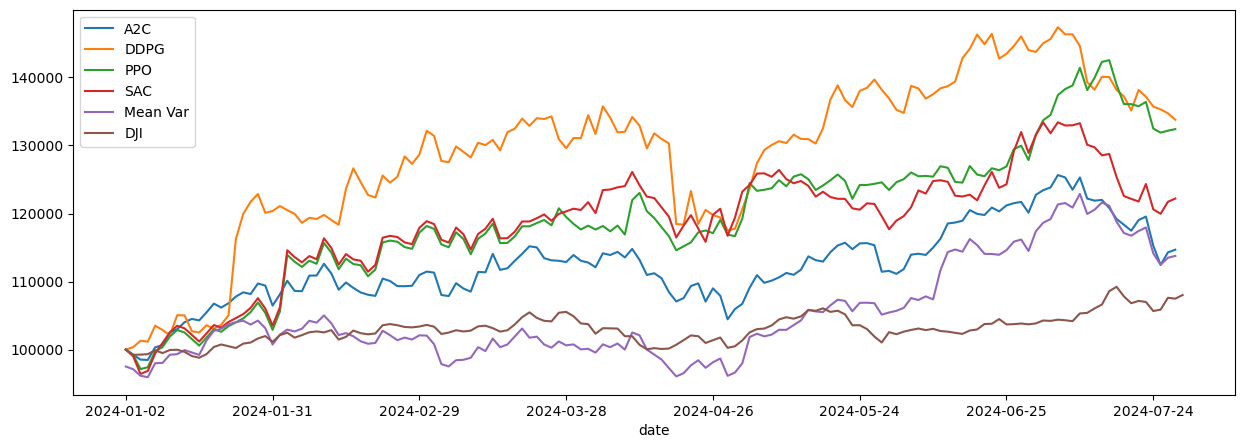

In [58]:
# Postavljanje veličine figure za grafikone i crtanje grafikona performansi strategija trgovanja.
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

Na temelju vrijednosti portfolija računamo dnevne povrate 

In [59]:
from pyfolio import timeseries
import pandas as pd

# Lista strategija za koje želite generirati statistike
strategies = ['A2C', 'DDPG', 'PPO', 'TD3', 'SAC', "Mean Var", "DJI"]

for strategy in strategies:
    column_name = f'{strategy}'
    if column_name in result.columns:
        # Izračunavanje dnevnih povrata iz vrijednosti portfelja
        result[f'{strategy}_returns'] = result[column_name].pct_change()

/opt/anaconda3/lib/python3.11/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(
/var/folders/28/0nrxt8bn57bdz8wy1xv7fb6m0000gn/T/ipykernel_83417/3649623815.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  result[f'{strategy}_returns'] = result[column_name].pct_change()
/var/folders/28/0nrxt8bn57bdz8wy1xv7fb6m0000gn/T/ipykernel_83417/3649623815.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  result[f'{strategy}_returns'] = result[column_name].pct_change()
/var/folders/28/0nrxt8bn57bdz8w

In [60]:
result.head()

,A2C,DDPG,PPO,SAC,Mean Var,DJI,A2C_returns,DDPG_returns,PPO_returns,SAC_returns,Mean Var_returns,DJI_returns
date,,,,,,,,,,,,
2024-01-02,100000.000000,100000.000000,100000.000000,100000.000000,97523.240634,100000.000000,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-03,99252.243042,100373.422089,99252.243042,99027.645691,97126.361254,99244.737210,-0.007478,0.003734,-0.007478,-0.009724,-0.004070,-0.007553
2024-01-04,98540.585022,101308.852875,97144.116364,96430.249756,96164.976317,99271.645408,-0.007170,0.009320,-0.021240,-0.026229,-0.009898,0.000271
2024-01-05,98489.761688,101179.589493,97420.825607,96877.138535,95950.130331,99339.972346,-0.000516,-0.001276,0.002848,0.004634,-0.002234,0.000688
2024-01-08,100346.475739,103520.059753,99772.724670,99451.758942,98010.392160,99915.080709,0.018852,0.023132,0.024142,0.026576,0.021472,0.005789


### Računamo povrate po odabranoj strategiji

In [61]:
# Pretpostavljamo da result DataFrame već sadrži vrijednosti portfelja za svaku strategiju
for strategy in strategies:
    # Provjerite postoji li strategija u DataFrame-u
    if f'{strategy}_returns' in result.columns:
        # Izvlačenje dnevnih povrata za trenutnu strategiju
        returns = result[f'{strategy}_returns'].dropna()
        returns.index = pd.to_datetime(returns.index)

        # Izračunavanje statistika performansi za trenutnu strategiju
        perf_stats = timeseries.perf_stats(returns=returns, factor_returns=None, positions=None, transactions=None, turnover_denom="AGB")

        # Ispis statistika performansi
        print(f"==============Strategy Stats ({strategy})==============")
        print(perf_stats)
        print("\n")
    else:
        print(f"Strategija {strategy} nije pronađena u rezultatima.\n")


==============Strategy Stats (A2C)==============
Annual return          0.271004
Cumulative returns     0.146866
Annual volatility      0.197535
Sharpe ratio           1.313001
Calmar ratio           2.579625
Stability              0.641634
Max drawdown          -0.105056
Omega ratio            1.241335
Sortino ratio          1.861488
Skew                  -0.517808
Kurtosis               0.376738
Tail ratio             0.792513
Daily value at risk   -0.023858
dtype: float64


==============Strategy Stats (DDPG)==============
Annual return          0.664234
Cumulative returns     0.337853
Annual volatility      0.300954
Sharpe ratio           1.842776
Calmar ratio           4.946243
Stability              0.651304
Max drawdown          -0.134291
Omega ratio            1.409611
Sortino ratio          2.997485
Skew                   0.446536
Kurtosis               8.849126
Tail ratio             1.312874
Daily value at risk   -0.035716
dtype: float64


==============Strategy Stats (PPO)=

### Plotiramo komulativne povrate za pojedinu strategiju

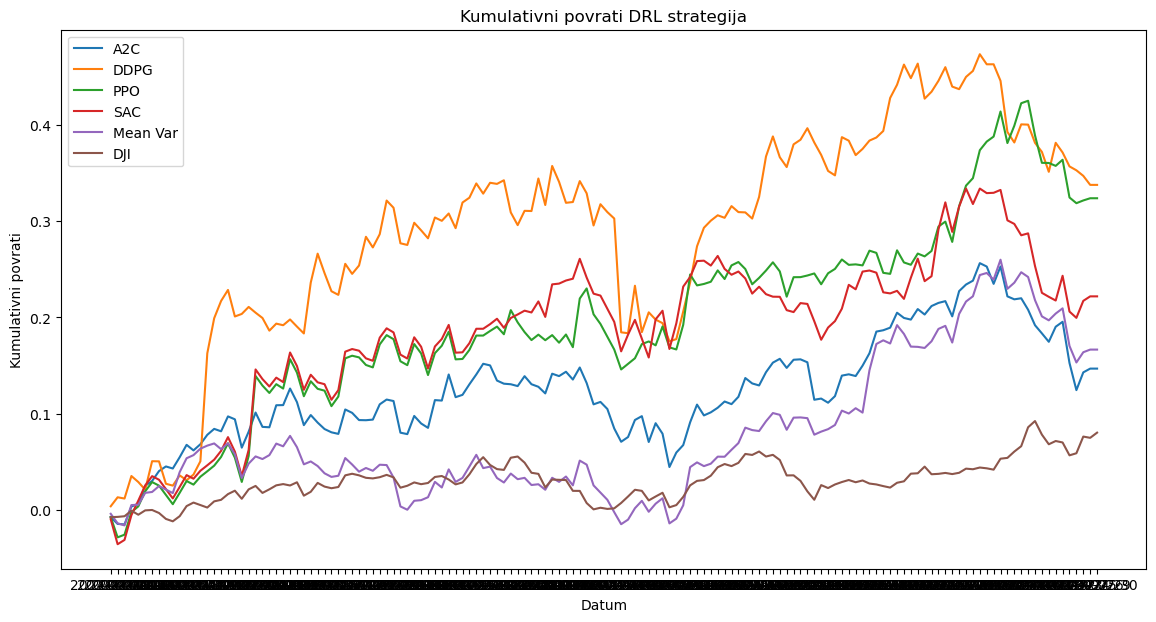

In [62]:
import matplotlib.pyplot as plt

# Postavljanje veličine figure za grafikon
plt.figure(figsize=(14, 7))

# Prolazak kroz svaku strategiju i crtanje njenih kumulativnih povrata
for strategy in strategies:
    if f'{strategy}_returns' in result.columns:
        # Izvlačenje dnevnih povrata za trenutnu strategiju i pretvaranje u decimalni format ako je potrebno
        returns = result[f'{strategy}_returns'].dropna() + 1  # Dodaje 1 za korištenje cumprod()

        # Izračunavanje kumulativnih povrata
        cumulative_returns = returns.cumprod() - 1  # Oduzima 1 na kraju za prikazivanje pravog kumulativnog povrata

        # Plotiranje kumulativnih povrata
        plt.plot(cumulative_returns.index, cumulative_returns, label=strategy)

# Dodavanje naslova i legende na grafikon
plt.title('Kumulativni povrati DRL strategija')
plt.legend()

# Postavljanje oznaka za x i y osi
plt.xlabel('Datum')
plt.ylabel('Kumulativni povrati')

# Prikazivanje grafikona
plt.show()


### Spremamo rezultate u CSV
Potrebno promjeniti za svakog agenta

In [64]:
import pickle

# Za ppo
with open('results/7. PORTFOLIO/primorl_df_account_value_ppo.pkl', 'wb') as f:
    pickle.dump(df_account_value_ppo, f)
    
# Za a2c
with open('results/7. PORTFOLIO/primorl_df_account_value_a2c.pkl', 'wb') as f:
    pickle.dump(df_account_value_a2c, f)

# Za ddpg
with open('results/7. PORTFOLIO/primorl_df_account_value_ddpg.pkl', 'wb') as f:
    pickle.dump(df_account_value_ddpg, f)

# Za td3
with open('results/7. PORTFOLIO/primorl_df_account_value_td3.pkl', 'wb') as f:
    pickle.dump(df_account_value_td3, f)

# Za sac
with open('results/7. PORTFOLIO/primorl_df_account_value_sac.pkl', 'wb') as f:
    pickle.dump(df_account_value_sac, f)

# Za mean var
with open('results/7. PORTFOLIO/primorl_mean_var.pkl', 'wb') as f:
    pickle.dump(MVO_result, f)

# Za dji
with open('results/7. PORTFOLIO/primorl_dji.pkl', 'wb') as f:
    pickle.dump(dji, f)